In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [2]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [3]:
df_train_obs_A=df_train_obs_A.drop(columns=['snow_density:kgm3'])
df_train_est_A=df_train_est_A.drop(columns=['snow_density:kgm3','date_calc'])


In [4]:
df_train_obs_A = df_train_obs_A.fillna(0)
df_train_est_A = df_train_est_A.fillna(0)
df = pd.concat([df_train_obs_A,df_train_est_A])
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [5]:
data = df

In [6]:
model = RandomForestRegressor()

In [7]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [8]:
model.fit(X_train,y_train)

RandomForestRegressor()

In [9]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = data['pv_measurement']


C:\Users\claxl\AppData\Local\Temp\ipykernel_31476\2409565943.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['pv_measurement'] = data['pv_measurement']


In [10]:
from sklearn.neighbors import LocalOutlierFactor
df = X_selected
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]

In [11]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

# Sample DataFrame (replace this with your own dataset)
data = df

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 2


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [17]:
def objective(trial):
    params = {
            'criterion' : 'absolute_error',
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            'max_features': trial.suggest_categorical('max_features',['sqrt','log2',None]),
            'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 1,500),
    }
    model = RandomForestRegressor(**params)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')

        # Train the XGBoost model
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [18]:
import optuna
import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize',pruner=optuna.pruners.MedianPruner())

[I 2023-10-26 10:28:39,450] A new study created in memory with name: no-name-c1b63805-ea3a-4961-8ffb-d9ebc4b1e0ae


In [19]:
study.optimize(objective, n_trials=20)

Mean Absolute Error: 189.46878319157562


[W 2023-10-26 12:48:56,883] Trial 0 failed with parameters: {'n_estimators': 254, 'max_depth': 42, 'min_samples_split': 119, 'min_samples_leaf': 59, 'max_features': None, 'max_leaf_nodes': 113} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\claxl\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\claxl\AppData\Local\Temp\ipykernel_31476\2873245054.py", line 26, in objective
    model.fit(X_train, y_train)
  File "C:\Users\claxl\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\claxl\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "C:\Users\claxl\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65

KeyboardInterrupt: 

In [ ]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

In [29]:
param = {'lambda': 0.028993356476131854, 'alpha': 0.005183879031858559, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.34137570532335176, 'n_estimators': 139, 'max_depth': 5, 'random_state': 273, 'min_child_weight': 264}

In [30]:
model_A = xgb.XGBRegressor(**param)

In [31]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [32]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

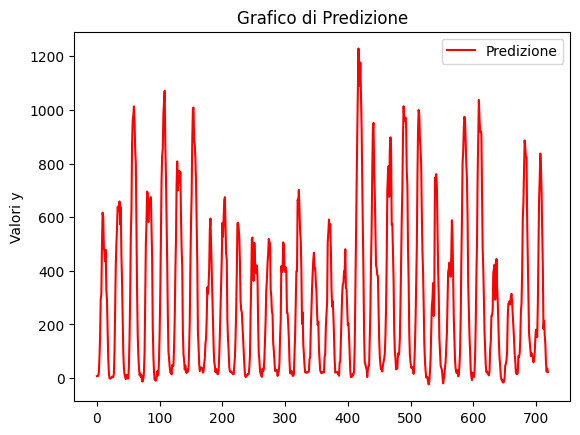

In [33]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [34]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [35]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [37]:
df.to_csv('B.csv')

In [17]:
X_test.isna().mean()

absolute_humidity_2m:gm3          0.0
air_density_2m:kgm3               0.0
ceiling_height_agl:m              0.0
clear_sky_energy_1h:J             0.0
clear_sky_rad:W                   0.0
cloud_base_agl:m                  0.0
dew_point_2m:K                    0.0
diffuse_rad:W                     0.0
diffuse_rad_1h:J                  0.0
direct_rad:W                      0.0
direct_rad_1h:J                   0.0
effective_cloud_cover:p           0.0
fresh_snow_24h:cm                 0.0
msl_pressure:hPa                  0.0
precip_5min:mm                    0.0
precip_type_5min:idx              0.0
pressure_100m:hPa                 0.0
pressure_50m:hPa                  0.0
relative_humidity_1000hPa:p       0.0
sfc_pressure:hPa                  0.0
snow_water:kgm2                   0.0
sun_azimuth:d                     0.0
sun_elevation:d                   0.0
super_cooled_liquid_water:kgm2    0.0
t_1000hPa:K                       0.0
total_cloud_cover:p               0.0
visibility:m

In [36]:
n_estimators = np.arange(1, 201) # number of trees in the random forest
max_features = [None] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = np.arange(1, 11) # minimum sample number to split a node
min_samples_leaf = np.arange(1, 11) # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [37]:
rf = RandomForestRegressor()

In [38]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, verbose=3, random_state=42, n_jobs = -1, scoring = 'neg_mean_absolute_error')

In [39]:
maelist = []
for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')

        # Train the XGBoost model
        rf_random.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf_random.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
mean_mae = np.mean(maelist)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean Absolute Error: 190.4619117807617
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean Absolute Error: 191.38119400284674


In [40]:
rf_random.best_params_

{'n_estimators': 156,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': 30,
 'bootstrap': True}

In [41]:
mean_mae

190.92155289180423